# SVM Quadratic Programming Example

In the quadratic programming problem, we aim to find $\textbf{x}$ satisfying
$$ \begin{array}{rl} \text{min}_{\textbf{x}} & \frac{1}{2}\textbf{x}^\top \texttt{Q} \textbf{x} + \textbf{c}^\top\textbf{x} \\ \text{subject to} & \texttt{A}\textbf{x} \le \textbf{b} \\
& \texttt{E}\textbf{x} = \textbf{d} .\end{array}$$

We can use the quadprog or cvxopt packages in Python as follows. I'm using the little wrappers from
[this nice blog about QP in Python](https://scaron.info/blog/quadratic-programming-in-python.html).

To install on Ubuntu, you'll want to do

    % pip3 install cython
    % pip3 install quadprog
    % pip3 install cvxopt

## A wrapper for quadprog

Once quadprog is installed, we can define a function `quadprog_solve_qp()` to find $\textbf{x}^*$:

The transformation of the variables is because quadprog's model is slightly different.

## A wrapper for cvxopt

Once cvxopt is installed, we can define a function `cvxopt_solv_qp()` to find $\textbf{x}^*$ likewise:

In [17]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))

Note that cvxopt uses its own data type for the matrix inputs, so we have to convert the numpy matrices to cvxopt matrices.

## Example problem

Anyway, given this solver function, let's try to solve a simple example such as the one from the blog mentioned above:

$$\begin{array}{rl} \min_{\textbf{x}} & \left\| \begin{bmatrix} 1 & 2 & 0 \\ -8 & 3 & 2 \\ 0 & 1 & 1 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix}-\begin{bmatrix} 3 \\ 2 \\ 3 \end{bmatrix} \right\|^2 \\
\text{subject to} & \begin{bmatrix} 1 & 2 & 1 \\ 2 & 0 & 1 \\ -1 & 2 & -1 \end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \\ x_3 \end{bmatrix} \le \begin{bmatrix} 3 \\ 2 \\ -2 \end{bmatrix} \end{array} $$

In [18]:
# Convert problem to standard representation 1/2 x.T Q x + c.T x s.t A x <= b
# then into quadprog's representation 1/2 x.T Q x - c.T s.t. A x >= b

M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
Q = np.dot(M.T, M)
c = np.dot(np.array([3., 2., 3.]), M).reshape((3,))
A = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
b = np.array([3., 2., -2.]).reshape((3,))


print("Cvxopt solution:")
print(cvxopt_solve_qp(Q, c, A, b))

Cvxopt solution:
     pcost       dcost       gap    pres   dres
 0: -3.2822e+00 -9.6005e+00  6e+00  4e-17  9e-01
 1: -6.9907e+00 -8.3734e+00  1e+00  1e-16  3e-01
 2: -1.0434e+01 -1.1566e+01  1e+00  5e-16  6e-16
 3: -1.0492e+01 -1.0506e+01  1e-02  7e-16  2e-16
 4: -1.0495e+01 -1.0495e+01  1e-04  4e-16  4e-16
 5: -1.0495e+01 -1.0495e+01  1e-06  2e-16  1e-16
Optimal solution found.
[-0.49025721 -1.57755278 -0.66484775]


## Example of finding the maximum margin hyperplane

OK, now let's try to use quadprog to find the maximum margin hyperplane separating two classes.

Suppose we want to predict whether a person is male or female based on their height and weight.

I generated some fake data for heights and weights and planted 3 points to force a maximum margin hyperplane of

$$\mathbf{w}^* = \begin{bmatrix} 0.64018 \\ 0.76822 \end{bmatrix} \; \; \; b^* = -153.32 .$$

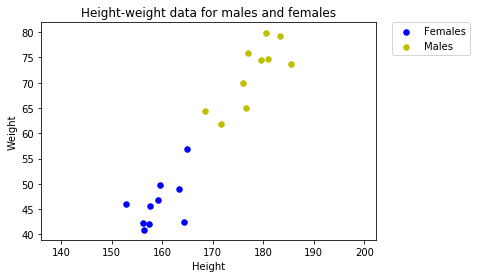

In [19]:
import matplotlib.pyplot as plt

Xf = np.matrix([[ 164.939, 163.431, 157.554, 152.785, 156.385, 159.242, 156.281, 164.411, 157.308, 159.579 ],
                [  56.927,  48.945,  45.678,  45.969,  40.896,  46.848,  42.225,  42.380,  42.150,  49.739 ]]).T;
Xm = np.matrix([[ 168.524, 171.597, 179.469, 176.063, 180.939, 177.011, 183.284, 180.549, 176.502, 185.392 ],
                [  64.353,  61.793,  74.552,  69.851,  74.730,  75.871,  79.170,  79.753,  64.923,  73.665 ]]).T;
X = np.concatenate([Xf, Xm],0);
y = np.concatenate([-np.matrix(np.ones([10,1])),np.matrix(np.ones([10,1]))]);

def plot_mf(Xf,Xm):
    axes = plt.axes()
    females_series = plt.scatter(np.array(Xf[:,0]), np.array(Xf[:,1]), s=30, c='b', marker='o', label='Females')
    males_series = plt.scatter(np.array(Xm[:,0]), np.array(Xm[:,1]), s=30, c='y', marker='o', label='Males')
    axes.set_aspect('equal', 'datalim')
    plt.xlabel('Height')
    plt.ylabel('Weight')
    plt.title('Height-weight data for males and females')
    plt.legend(handles=[females_series, males_series], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_mf(Xf,Xm)

We now know that the SVM optimization problem in the linearly separable case is to
find $\mathbf{w},b$ satisfying
$$ \begin{array}{rl} \min_{\mathbf{w},b} & \|\mathbf{w}\| \\
                     \text{subject to} & y^{(i)}(\mathbf{w}^\top\mathbf{x}^{(i)}+b)\ge 1, i \in 1..m
   \end{array}
$$

Hopefully you can see that to cast this problem as a QP problem, for the objective function, we just let
$$ \mathtt{Q} = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{bmatrix} \; \; \;
   \mathbf{c} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix} $$

$$\mathtt{A} = \begin{bmatrix} -y^{(1)}\mathbf{x}^{(1)\top} & -y^{(1)} \\
                               -y^{(2)}\mathbf{x}^{(2)\top} & -y^{(2)} \\
                               \vdots & \vdots \end{bmatrix} \;\;\;
  \mathbf{b} = \begin{bmatrix} -1 \\ -1 \\ \vdots \end{bmatrix} $$

Turns out that quadprog doesn't accept a Q that is non positive definite, but cvxopt is fine with it. So below we use cvxopt to find the optimal w and b:

In [20]:
Q = np.eye(3);
Q[2,2] = 0;
c = np.zeros([3])
A = np.multiply(np.tile(-y,[1, 3]), np.concatenate([X, np.ones([20,1])],1))
b = -np.ones([20])
x = cvxopt_solve_qp(Q, c, A, b);
w = np.matrix([[x[0]],[x[1]]]);
b = x[2];
scale = np.linalg.norm(w);
w = w / scale;
b = b / scale;
print('Optimal w: [%f %f] b: %f' % (w[0,0],w[1,0],b));

     pcost       dcost       gap    pres   dres
 0:  1.4721e-03  6.5053e+00  5e+01  2e+00  4e+02
 1:  1.0012e-02 -4.7161e+00  1e+01  6e-01  1e+02
 2:  2.6180e-02 -4.8172e+00  7e+00  2e-01  6e+01
 3:  3.9767e-02 -4.5363e-01  5e-01  1e-02  2e+00
 4:  3.5404e-02  1.8200e-02  2e-02  5e-15  1e-13
 5:  3.1392e-02  3.0877e-02  5e-04  4e-15  3e-12
 6:  3.1250e-02  3.1245e-02  5e-06  4e-15  2e-13
 7:  3.1249e-02  3.1248e-02  5e-08  5e-15  2e-13
Optimal solution found.
Optimal w: [0.640061 0.768324] b: -153.309495


## Example of solving the dual optimization problem

Now let's see if we can use cvxopt to solve the dual optimization

$$ \begin{array}{rl}
  \max_{\mathbf{\alpha}} & W(\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i,j=1}^m y^{(i)} y^{(j)} \alpha_i \alpha_j \left< \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right> \\
  \text{such that} & \alpha_i \ge 0, i \in 1..m \\
                   & \sum_{i=1}^m \alpha_i y^{(i)} = 0
\end{array} $$

We need to negate our objective function to turn the max (SVM formulation) into a min (QP formalation).

For the second term of $W(\mathbf{\alpha})$, first let $\mathtt{K}$ be the kernel matrix with $\mathtt{K}_{ij} = \left< \mathbf{x}^{(i)}, \mathbf{x}^{(j)} \right>$. Then $\mathbf{\alpha}^\top \text{diag}(\mathbf{y}) \mathtt{K} \text{diag}(\mathbf{y}) \mathbf{\alpha}$ gives us the summation in the second term ($\text{diag}(\mathbf{y})$ is just the square diagonal matrix with $\mathbf{y}$ as its diagonal).

The (negated) first term of $W(\mathbf{\alpha})$ can be written in QP form with $\mathbf{c} = \begin{bmatrix} -1 & -1 & \ldots \end{bmatrix}^\top$.

So that gives us our QP setup:
$$ \mathtt{Q} = \text{diag}(\mathbf{y}) \mathtt{K} \text{diag}(\mathbf{y}) \; \; \;
   \mathbf{c} = \begin{bmatrix} -1 \\ -1 \\ \vdots \end{bmatrix} $$

$$\mathtt{A} = -\mathtt{I}_{m\times m} \;\;\;
  \mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ \vdots \end{bmatrix} $$

$$\mathtt{E} = \mathbf{y}^\top \;\;\;
  \mathbf{d} = \begin{bmatrix} 0 \end{bmatrix}. $$

OK, now the code:

Q rank: 2
     pcost       dcost       gap    pres   dres
 0: -2.7646e+00 -4.9725e+00  5e+01  6e+00  2e+00
 1: -6.4101e+00 -3.8299e+00  1e+01  2e+00  6e-01
 2: -5.0055e+00 -1.2719e+00  7e+00  8e-01  2e-01
 3: -5.1552e-02 -4.0648e-02  5e-01  3e-02  1e-02
 4: -1.8200e-02 -3.5404e-02  2e-02  1e-17  2e-13
 5: -3.0877e-02 -3.1392e-02  5e-04  8e-18  2e-13
 6: -3.1245e-02 -3.1250e-02  5e-06  1e-17  3e-13
 7: -3.1248e-02 -3.1249e-02  5e-08  8e-18  1e-13
Optimal solution found.
Optimal alpha:
[3.12484796e-02 1.13821985e-09 7.68004003e-10 6.22346942e-10
 6.43114906e-10 8.93974185e-10 6.60695980e-10 4.31409827e-10
 6.68557407e-10 1.19689394e-09 1.56332821e-02 1.56151999e-02
 5.00606721e-10 6.71834910e-10 4.89168003e-10 4.93113729e-10
 4.90935291e-10 4.85894510e-10 9.54348935e-10 4.42078646e-10]
Optimal w: [0.640062,0.768324] b: -153.309583


/home/prithvi/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/prithvi/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


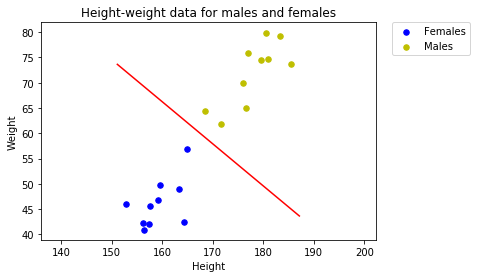

In [22]:
m = X.shape[0];
n = X.shape[1];

# Transform data set so that each attribute has a
# mean of 0 and a standard deviation of 1

def preprocess(X):
    means = X.mean(0);
    scales = 1/np.std(X,0);
    Xh = np.concatenate([X.T,np.ones([1,20])],0);
    Tm = np.matrix(np.eye(3));
    Tm[0:2,2:3] = -X.mean(0).T;
    Ts = np.matrix(np.eye(3));
    Ts[0:2,0:2] = np.diagflat(scales);
    T = Ts*Tm;
    XX = (T * Xh);
    XX = XX[0:2,:].T;
    return XX, T;

# RBF/Gaussian kernel

def gauss_kernel(X):
    sigma = 0.2
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = (X[i,:] - X[j,:]) * (X[i,:] - X[j,:]).T
    K = np.exp(-K/(2*sigma*sigma))      
    return K;

def linear_kernel(X):
    m = X.shape[0];
    K = np.matrix(np.zeros([m,m]));
    for i in range(0,m):
        for j in range(0,m):
            K[i,j] = X[i,:]*(X[j,:].T)
    return K;

# Linear kernel below. We might also try
# XX, T = preprocess(X)
# K = gauss_kernel(XX)
#print(X)
K = linear_kernel(X);
#print(K)
Q = np.multiply(y * y.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = -np.eye(m);
b = np.zeros([m]);
E = y.T;
d = np.zeros(1);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
print("Optimal alpha:")
print(alpha_star)

def get_wb(X, y, alpha):
    # Find the support vectors
    S = alpha > 1e-6 #threshold
    XS = X[S,:]
    yS = y[S]
    alphaS = alpha[S]
    alphaSyS = np.tile(np.multiply(yS.T, alphaS).T, n)
    w = sum(np.multiply(alphaSyS, XS)).T
    # Find b
    KS = K[S,:][:,S]
    NS = yS.shape[0]
    b = (np.sum(yS) - np.sum(np.multiply(alphaS,yS.T)*KS))/NS
    # Normalize w,b
    scalef = np.linalg.norm(w)
    w = w / scalef
    b = b / scalef
    return w,b

w,b = get_wb(X, y, alpha_star)

print("Optimal w: [%f,%f] b: %f" % (w[0],w[1],b))
plot_mf(Xf,Xm)

def plot_w(w,b):
    ylim = plt.axes().get_ylim()
    xlim = plt.axes().get_xlim()
    p1 = (xlim[0], - (w[0,0] * xlim[0] + b) / w[1,0])
    p2 = (xlim[1], - (w[0,0] * xlim[1] + b) / w[1,0])
    plt.plot((p1[0],p2[0]), (p1[1],p2[1]), 'r-')

plot_w(w,b)

## Regularized SVM

Now, let's imagine we want our model to perform reasonably with data that are not linearly separable or contain outliers. Consider our prior example of male and female heights and weights. Suppose we plant one outlier among the females:

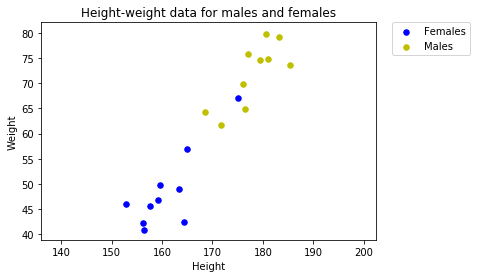

In [23]:
import matplotlib.pyplot as plt

Xf = np.matrix([[ 164.939, 163.431, 157.554, 152.785, 156.385, 159.242, 156.281, 164.411, 175.000, 159.579 ],
                [  56.927,  48.945,  45.678,  45.969,  40.896,  46.848,  42.225,  42.380,  67.000,  49.739 ]]).T;
Xm = np.matrix([[ 168.524, 171.597, 179.469, 176.063, 180.939, 177.011, 183.284, 180.549, 176.502, 185.392 ],
                [  64.353,  61.793,  74.552,  69.851,  74.730,  75.871,  79.170,  79.753,  64.923,  73.665 ]]).T;
X = np.concatenate([Xf, Xm],0);
y = np.concatenate([-np.matrix(np.ones([10,1])),np.matrix(np.ones([10,1]))]);

plot_mf(Xf,Xm)

We know that the regularized SVM optimization problem

$$ \begin{array}{rl}
   \min_{\mathbf{w},b,\mathbf{\xi}} & \frac{1}{2} \| \textbf{w} \|^2 + C \sum_{i=1}^m \xi_i \\
   \text{such that} & y^{(i)}(\mathbf{w}^\top \vec{x}^{(i)} + b) \ge 1-\xi_i, i \in 1..m \\
                    & \xi_i \ge 0, i \in 1..m
   \end{array}
$$

has the dual form

$$ \begin{array}{rl}
   \max_{\mathbf{\alpha}} & W(\mathbf{\alpha}) = \sum_{i=1}^m \alpha_i - \frac{1}{2}\sum_{i,j=1}^m 
   y^{(i)}y^{(j)}\alpha_i\alpha_j k(\mathbf{x}^{(i)},\mathbf{x}^{(j)}) \\
   \text{such that} & 0 \le \alpha_i \le C, i \in 1..m \\
                    & \sum_{i=1}^m \alpha_i y^{(i)} = 0
   \end{array}
$$

So now we have the new QP setup

$$ \mathtt{Q} = \text{diag}(\mathbf{y}) \mathtt{K} \text{diag}(\mathbf{y}) \; \; \;
   \mathbf{c} = \begin{bmatrix} -1 \\ -1 \\ \vdots \end{bmatrix} $$

$$\mathtt{A} = \begin{bmatrix} -\mathtt{I}_{m\times m} \\ \mathtt{I}_{m\times m} \end{bmatrix} \;\;\;
  \mathbf{b} = \begin{bmatrix} 0 \\ \vdots \\ 0 \\ C \\ \vdots \\ C \end{bmatrix} $$

$$\mathtt{E} = \mathbf{y}^\top \;\;\;
  \mathbf{d} = \begin{bmatrix} 0 \end{bmatrix}. $$

OK, now the code:

In [24]:
C = 1
print(type(X))
m = X.shape[0];
n = X.shape[1];

K = linear_kernel(X);

Q = np.multiply(y * y.T, K)
print('Q rank: %d' % np.linalg.matrix_rank(Q))
c = -np.ones([m]);
A = np.concatenate([-np.eye(m), np.eye(m)], 0);
b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
E = y.T;
d = np.zeros(1);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);
print(alpha_star)

<class 'numpy.matrix'>
Q rank: 2
     pcost       dcost       gap    pres   dres
 0: -5.0020e+00 -3.4017e+01  1e+02  2e+00  1e-11
 1: -3.5248e+00 -1.7152e+01  2e+01  1e-01  1e-11
 2: -3.2459e+00 -4.9872e+00  2e+00  2e-02  6e-12
 3: -3.4368e+00 -3.7432e+00  4e-01  3e-03  7e-12
 4: -3.4213e+00 -3.4307e+00  1e-02  4e-05  8e-12
 5: -3.4237e+00 -3.4238e+00  1e-04  4e-07  8e-12
 6: -3.4238e+00 -3.4238e+00  1e-06  4e-09  5e-12
Optimal solution found.
[7.31427463e-01 9.43146879e-09 3.75049548e-09 4.54528991e-09
 7.84226257e-10 4.78164760e-09 1.37181876e-09 2.23773442e-09
 9.99999994e-01 9.59820321e-09 6.36052428e-01 9.99999969e-01
 5.85057252e-09 1.83824416e-08 6.43668603e-09 3.33570305e-09
 1.17365319e-09 1.01805494e-09 9.53750473e-02 1.32631095e-08]


Note that now we have 5 non-zero $\alpha_i$'s.

Optimal w: [-0.071276,0.997457] b: -49.913344


/home/prithvi/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/prithvi/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


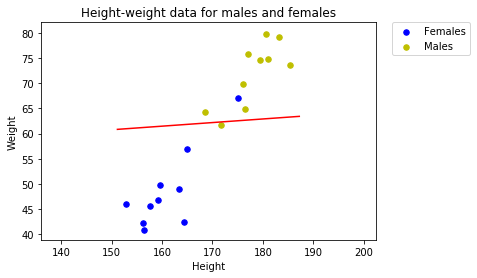

In [25]:
# Find w, b (note this is only useful if using linear kernel)

w,b = get_wb(X, y, alpha_star)

print("Optimal w: [%f,%f] b: %f" % (w[0],w[1],b))

plot_mf(Xf,Xm)
plot_w(w,b)


By decreasing C, we pay less attention to the outlier and more attention to the overall distibution of points:

     pcost       dcost       gap    pres   dres
 0: -2.5274e+00 -3.7118e-01  1e+02  1e+01  3e-12
 1: -6.6271e-02 -3.6791e-01  2e+00  1e-01  3e-12
 2: -3.9179e-02 -2.1137e-01  2e-01  8e-03  2e-13
 3: -3.7112e-02 -6.0650e-02  3e-02  8e-04  9e-14
 4: -4.1656e-02 -4.4878e-02  3e-03  7e-05  7e-14
 5: -4.2727e-02 -4.3079e-02  4e-04  2e-06  8e-14
 6: -4.2836e-02 -4.2840e-02  4e-06  3e-08  1e-13
 7: -4.2838e-02 -4.2838e-02  4e-08  3e-10  8e-14
Optimal solution found.
Optimal w: [0.527719,0.849419] b: -141.234720


/home/prithvi/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/prithvi/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


array([9.99999886e-03, 3.80538010e-03, 7.87435604e-10, 7.44978751e-10,
       5.70749526e-10, 6.94821246e-10, 6.19420446e-10, 2.05210981e-10,
       9.99999964e-03, 6.94171146e-09, 9.99999760e-03, 9.99999810e-03,
       7.79591781e-10, 2.32236699e-09, 7.05252248e-10, 7.75102119e-10,
       4.24900509e-10, 4.62417112e-10, 3.80538739e-03, 6.14708209e-10])

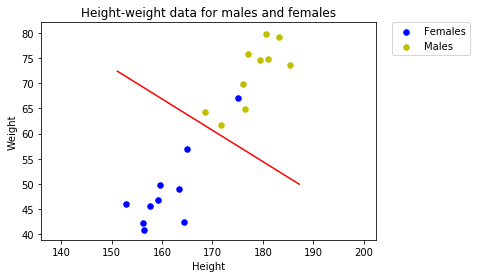

In [9]:
C = 0.01
b = np.concatenate([np.zeros([m]), C*np.ones([m])], 0);
alpha_star = cvxopt_solve_qp(Q, c, A, b, E, d);

w,b = get_wb(X, y, alpha_star)

print("Optimal w: [%f,%f] b: %f" % (w[0],w[1],b))

plot_mf(Xf,Xm)
plot_w(w,b)
alpha_star